# PCOS Diagnosis using Machine Learning

# Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

from collections import Counter
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, accuracy_score

In [3]:
data = pd.read_csv('pcos_data1.csv')
print(data)

     Sl. No  Patient File No.  PCOS (Y/N)   Age (yrs)   BMI  Cycle(R/I)  \
0         1                 1           0          28  19.3           2   
1         2                 2           0          36  24.9           2   
2         3                 3           1          33  25.3           2   
3         4                 4           0          37  29.7           2   
4         5                 5           0          25  20.1           2   
..      ...               ...         ...         ...   ...         ...   
536     537               537           0          35  18.5           2   
537     538               538           0          30  25.3           2   
538     539               539           0          36  23.4           2   
539     540               540           0          27  22.2           4   
540     541               541           1          23  30.1           4   

     Cycle length(days)  FSH(mIU/mL)  FSH/LH AMH(ng/mL)  Weight gain(Y/N)  \
0                     

# Examine the data

In [4]:
data.shape

(541, 14)

In [5]:

data.head()

,Sl. No,Patient File No.,PCOS (Y/N),Age (yrs),BMI,Cycle(R/I),Cycle length(days),FSH(mIU/mL),FSH/LH,AMH(ng/mL),Weight gain(Y/N),Follicle No. (L),Follicle No. (R),Avg. F size (L) (mm)
0,1,1,0,28,19.3,2,5,7.95,2.16,2.07,0,3,3,18.0
1,2,2,0,36,24.9,2,5,6.73,6.17,1.53,0,3,5,15.0
2,3,3,1,33,25.3,2,5,5.54,6.30,6.63,0,13,15,18.0
3,4,4,0,37,29.7,2,5,8.06,3.42,1.22,0,2,2,15.0
4,5,5,0,25,20.1,2,5,3.98,4.42,2.26,0,3,4,16.0


In [6]:
data.columns

Index(['Sl. No', 'Patient File No.', 'PCOS (Y/N)', ' Age (yrs)', 'BMI',
       'Cycle(R/I)', 'Cycle length(days)', 'FSH(mIU/mL)', 'FSH/LH',
       'AMH(ng/mL)', 'Weight gain(Y/N)', 'Follicle No. (L)',
       'Follicle No. (R)', 'Avg. F size (L) (mm)'],
      dtype='object')

In [7]:
data.sample(5)

,Sl. No,Patient File No.,PCOS (Y/N),Age (yrs),BMI,Cycle(R/I),Cycle length(days),FSH(mIU/mL),FSH/LH,AMH(ng/mL),Weight gain(Y/N),Follicle No. (L),Follicle No. (R),Avg. F size (L) (mm)
484,485,485,0,31,25.9,2,5,5.28,1.53,6.26,0,9,10,18.0
538,539,539,0,36,23.4,2,6,11.96,4.30,3.7,0,1,0,18.0
19,20,20,1,30,31.2,4,7,1.89,2.33,2.07,0,16,8,18.0
195,196,196,1,35,25.5,4,4,22.00,6.49,6.65,1,8,10,15.0
314,315,315,1,34,22.0,2,6,6.47,1.16,5.4,0,5,5,12.0


## DATA PREPROCESSING

Checking for duplicate values

In [8]:
data_dup=data.duplicated().any()
data_dup

False

Check null values in data set

In [9]:
data.isnull().sum()

Sl. No                  0
Patient File No.        0
PCOS (Y/N)              0
 Age (yrs)              0
BMI                     0
Cycle(R/I)              0
Cycle length(days)      0
FSH(mIU/mL)             0
FSH/LH                  0
AMH(ng/mL)              0
Weight gain(Y/N)        0
Follicle No. (L)        0
Follicle No. (R)        0
Avg. F size (L) (mm)    0
dtype: int64

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541 entries, 0 to 540
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Sl. No                541 non-null    int64  
 1   Patient File No.      541 non-null    int64  
 2   PCOS (Y/N)            541 non-null    int64  
 3    Age (yrs)            541 non-null    int64  
 4   BMI                   541 non-null    float64
 5   Cycle(R/I)            541 non-null    int64  
 6   Cycle length(days)    541 non-null    int64  
 7   FSH(mIU/mL)           541 non-null    float64
 8   FSH/LH                541 non-null    float64
 9   AMH(ng/mL)            541 non-null    object 
 10  Weight gain(Y/N)      541 non-null    int64  
 11  Follicle No. (L)      541 non-null    int64  
 12  Follicle No. (R)      541 non-null    int64  
 13  Avg. F size (L) (mm)  541 non-null    float64
dtypes: float64(4), int64(9), object(1)
memory usage: 59.3+ KB


In [11]:
cate_val = []
cont_val = []
for column in data.columns:
    if data[column].nunique() <=10:
        cate_val.append(column)
    else:
        cont_val.append(column)

In [12]:
cate_val

['PCOS (Y/N)', 'Cycle(R/I)', 'Weight gain(Y/N)']

In [13]:
cont_val

['Sl. No',
 'Patient File No.',
 ' Age (yrs)',
 'BMI',
 'Cycle length(days)',
 'FSH(mIU/mL)',
 'FSH/LH',
 'AMH(ng/mL)',
 'Follicle No. (L)',
 'Follicle No. (R)',
 'Avg. F size (L) (mm)']

In [14]:
# Changing the title of the properties.

data = data.rename(columns = {"PCOS (Y/N)":"Target"})

In [15]:
# Dropping unnecessary features.

data = data.drop(["Sl. No","Patient File No."],axis =1)

In [16]:
data.info(verbose = True, null_counts = False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541 entries, 0 to 540
Data columns (total 12 columns):
 #   Column                Dtype  
---  ------                -----  
 0   Target                int64  
 1    Age (yrs)            int64  
 2   BMI                   float64
 3   Cycle(R/I)            int64  
 4   Cycle length(days)    int64  
 5   FSH(mIU/mL)           float64
 6   FSH/LH                float64
 7   AMH(ng/mL)            object 
 8   Weight gain(Y/N)      int64  
 9   Follicle No. (L)      int64  
 10  Follicle No. (R)      int64  
 11  Avg. F size (L) (mm)  float64
dtypes: float64(4), int64(7), object(1)
memory usage: 50.8+ KB


In [17]:
# Having a look at the data with dtype objects.

data["AMH(ng/mL)"].head() 

0    2.07
1    1.53
2    6.63
3    1.22
4    2.26
Name: AMH(ng/mL), dtype: object

In [18]:
# Dealing with categorical values.
# In this database the type objects are numeric values saved as strings.
# So I am just converting it into a numeric value.

data["AMH(ng/mL)"] = pd.to_numeric(data["AMH(ng/mL)"], errors='coerce')


In [19]:
# Dealing with missing values. 
# Filling NA values with the median of that feature.
data['AMH(ng/mL)'].fillna(data['AMH(ng/mL)'].median(),inplace=True)

In [20]:
# Clearing up the extra space in the column names.S
data.columns = [col.strip() for col in data.columns]

In [21]:
colors = ['#670067','#008080']

In [22]:
def bar_plot(variable):
    """
     input: variable example : Target
     output: bar plot & value count
     
    """
    # Get feature
    var = data[variable]
    # Count number of categorical variable(value/sample)
    varValue = var.value_counts()
    # Visualize
    plt.figure(figsize = (9,3))
    plt.bar(varValue.index,varValue,color=colors)
    plt.xticks(varValue.index,varValue.index.values)
    plt.ylabel("Count")
    plt.title(variable)
    plt.show()
    print("{}: \n {}".format(variable,varValue))

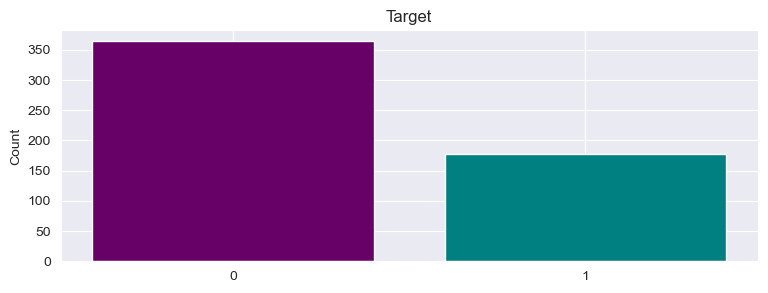

Target: 
 0    364
1    177
Name: Target, dtype: int64


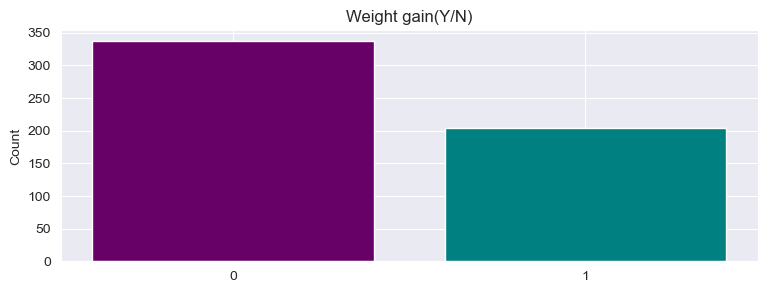

Weight gain(Y/N): 
 0    337
1    204
Name: Weight gain(Y/N), dtype: int64


In [23]:
category = ["Target",  "Weight gain(Y/N)"]
for c in category:
    bar_plot(c)

<AxesSubplot:xlabel='Cycle length(days)', ylabel='Density'>

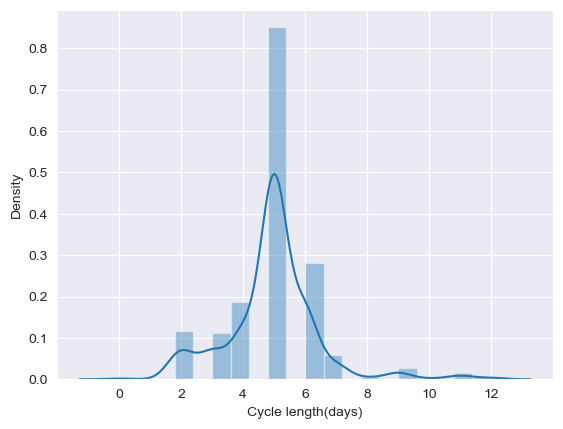

In [24]:
sns.distplot(data['Cycle length(days)'],bins=20)

 ### Numerical Variable

In [25]:
def plot_hist(variable):
    plt.figure(figsize = (9,3))
    plt.hist(data[variable], bins = 50,color=colors[1])
    plt.xlabel(variable)
    plt.ylabel("Frequency")
    plt.title("{} distribution with hist".format(variable))
    plt.show()

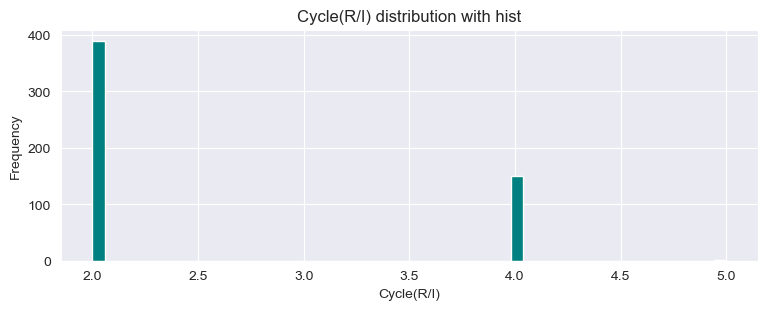

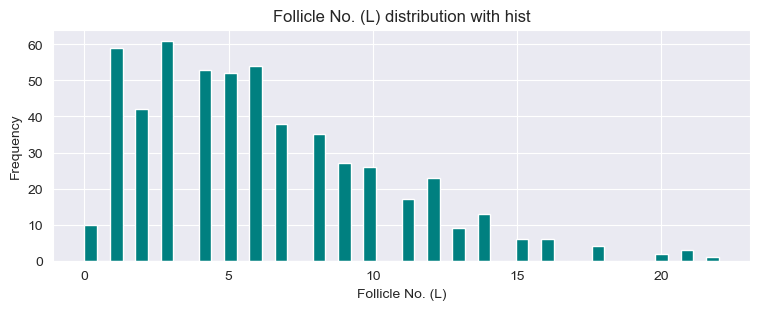

In [26]:
numericVar = ["Cycle(R/I)", "Follicle No. (L)"]
for n in numericVar:
    plot_hist(n)

### Statistical Measures/ EXPLORATORY DATA ANALYSIS (EDA)

In [27]:
data.describe()

,Target,Age (yrs),BMI,Cycle(R/I),Cycle length(days),FSH(mIU/mL),FSH/LH,AMH(ng/mL),Weight gain(Y/N),Follicle No. (L),Follicle No. (R),Avg. F size (L) (mm)
count,541.000000,541.000000,541.000000,541.000000,541.00000,541.000000,541.000000,541.000000,541.000000,541.000000,541.000000,541.000000
mean,0.327172,31.430684,24.307579,2.560074,4.94085,14.601832,6.904917,5.620634,0.377079,6.129390,6.641405,15.018115
std,0.469615,5.411006,4.055129,0.901950,1.49202,217.022081,60.691982,5.876742,0.485104,4.229294,4.436889,3.566839
min,0.000000,20.000000,12.400000,2.000000,0.00000,0.210000,0.000000,0.100000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,28.000000,21.600000,2.000000,4.00000,3.300000,1.420000,2.010000,0.000000,3.000000,3.000000,13.000000
50%,0.000000,31.000000,24.200000,2.000000,5.00000,4.850000,2.170000,3.700000,0.000000,5.000000,6.000000,15.000000
75%,1.000000,35.000000,26.600000,4.000000,5.00000,6.410000,3.960000,6.900000,1.000000,9.000000,10.000000,18.000000
max,1.000000,48.000000,38.900000,5.000000,12.00000,5052.000000,1372.830000,66.000000,1.000000,22.000000,20.000000,24.000000


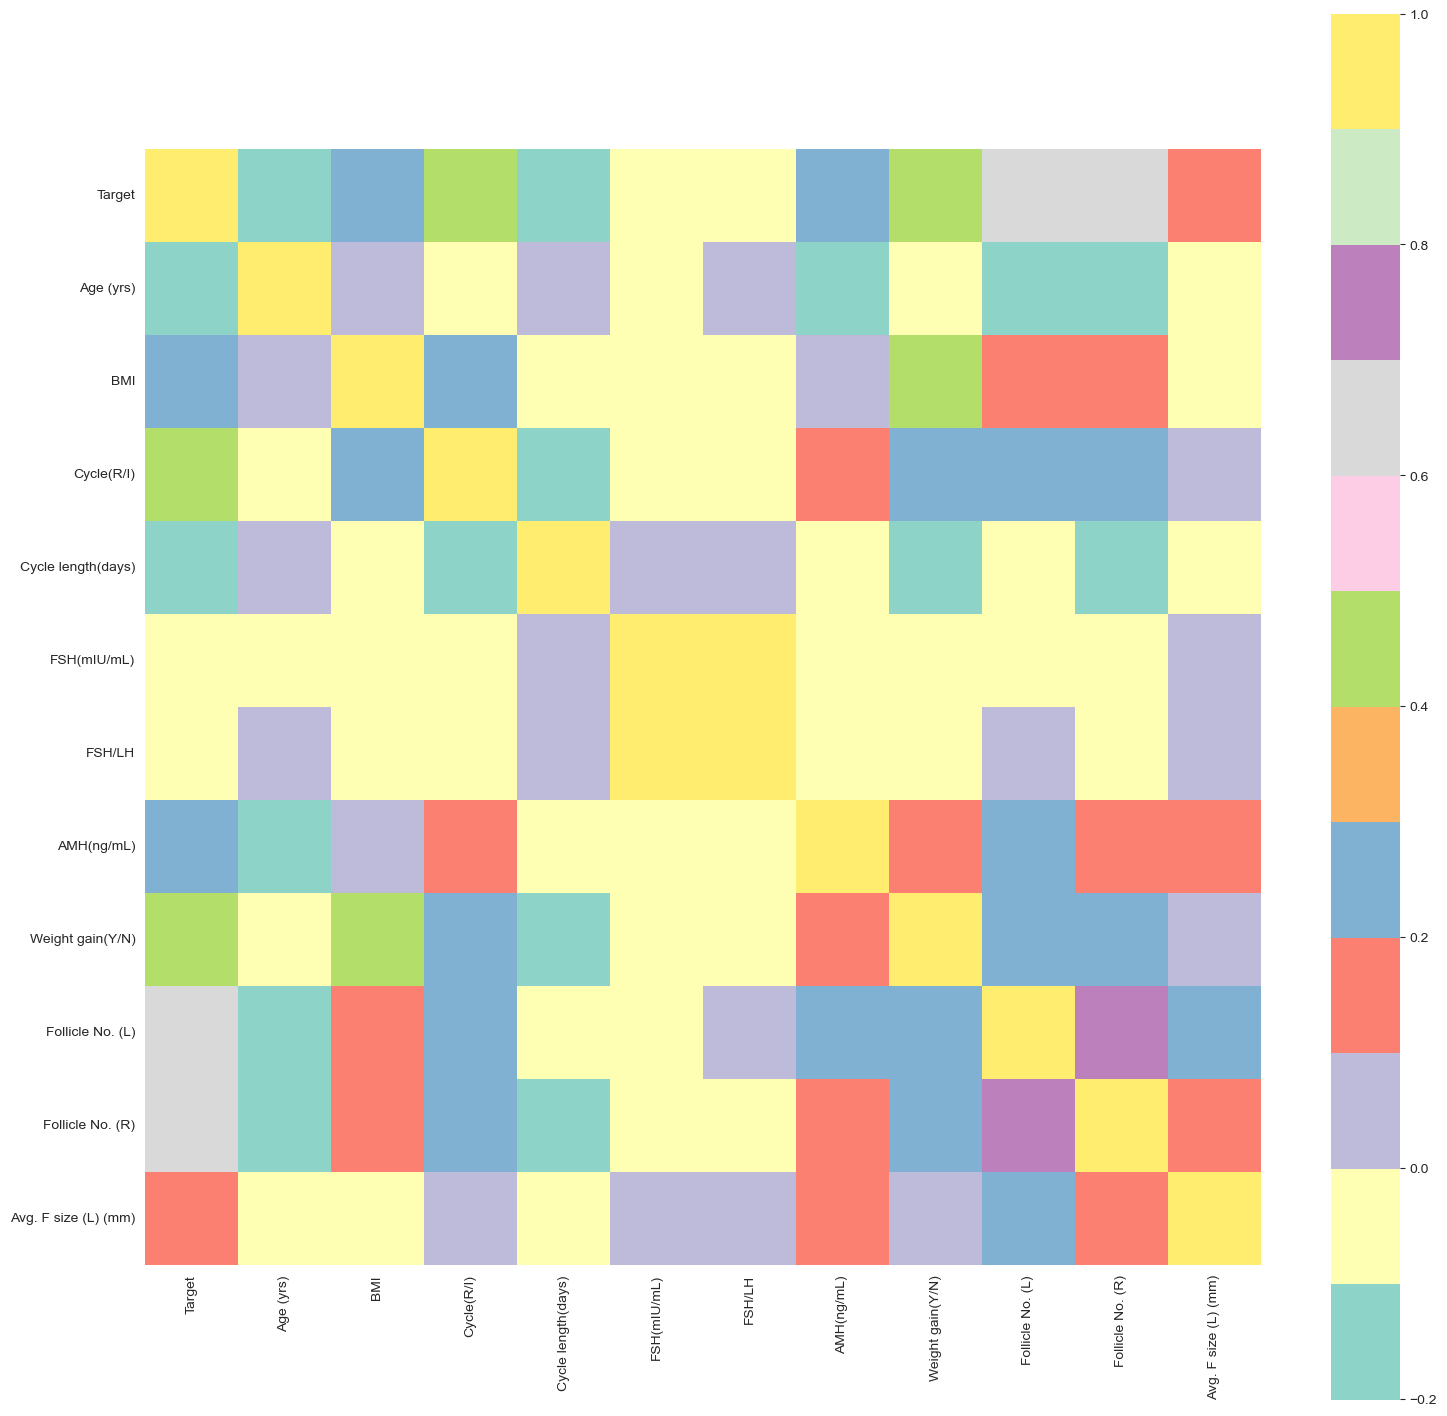

In [28]:
# Examaning a correlation matrix of all the features.

corrmat = data.corr()
plt.subplots(figsize=(18,18))
sns.heatmap(corrmat,cmap="Set3", square=True);

In [29]:
# How all the features correlate with the PCOS. 

corrmat['Target'].sort_values(ascending=False)

Target                  1.000000
Follicle No. (R)        0.648327
Follicle No. (L)        0.603346
Weight gain(Y/N)        0.441047
Cycle(R/I)              0.401644
AMH(ng/mL)              0.264141
BMI                     0.199697
Avg. F size (L) (mm)    0.132992
FSH/LH                 -0.018334
FSH(mIU/mL)            -0.030319
Age (yrs)              -0.168513
Cycle length(days)     -0.178480
Name: Target, dtype: float64

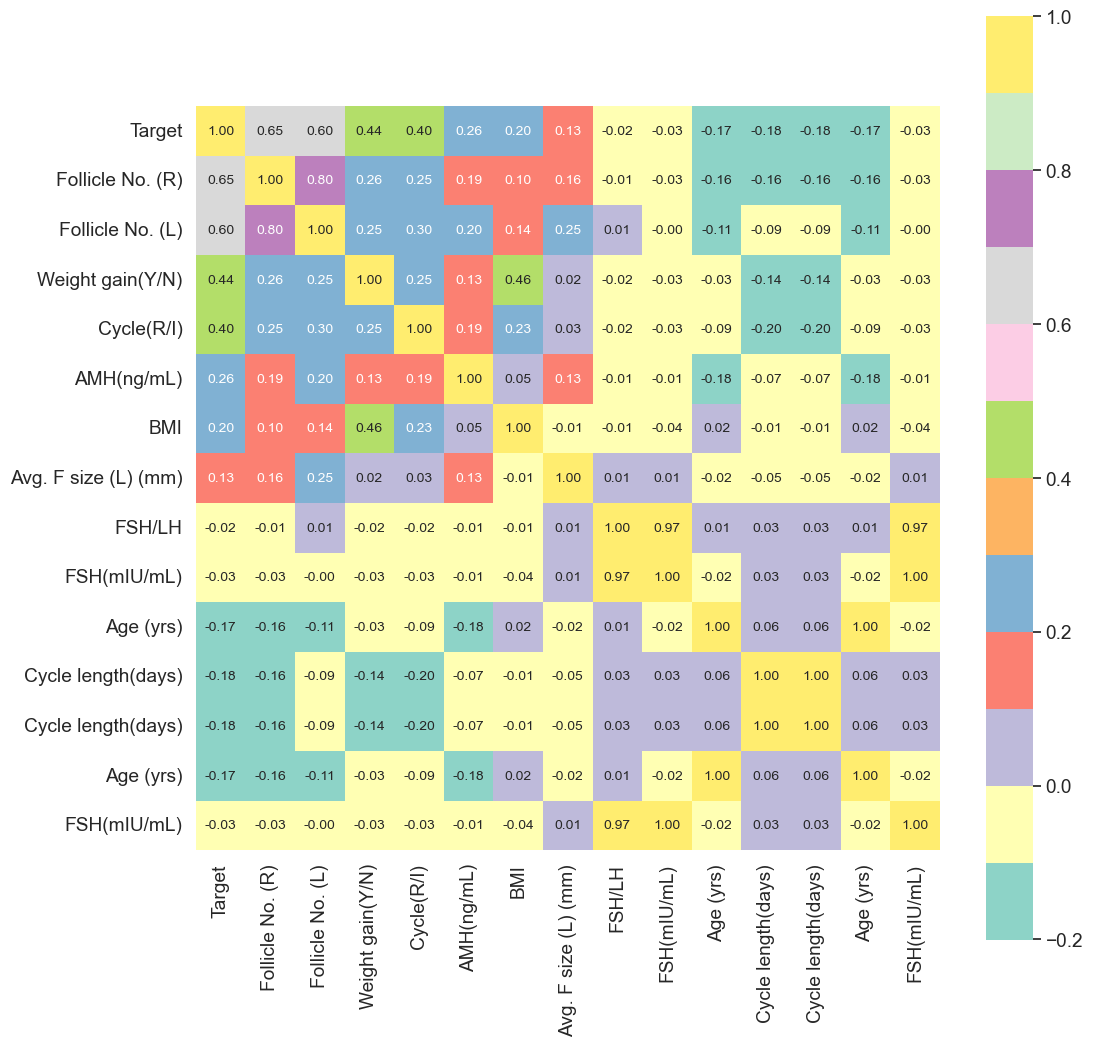

In [30]:
# Having a look at features bearing significant correlation.

plt.figure(figsize=(12,12))
k = 12 #number of variables with positive for heatmap
l = 3 #number of variables with negative for heatmap
cols_p = corrmat.nlargest(k,'Target')['Target'].index 
cols_n = corrmat.nsmallest(l, 'Target')['Target'].index
cols = cols_p.append(cols_n) 

cm = np.corrcoef(data[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True,cmap="Set3", annot=True, square=True, fmt='.2f', annot_kws={'size': 10},
                 yticklabels=cols.values, xticklabels=cols.values)
plt.show()

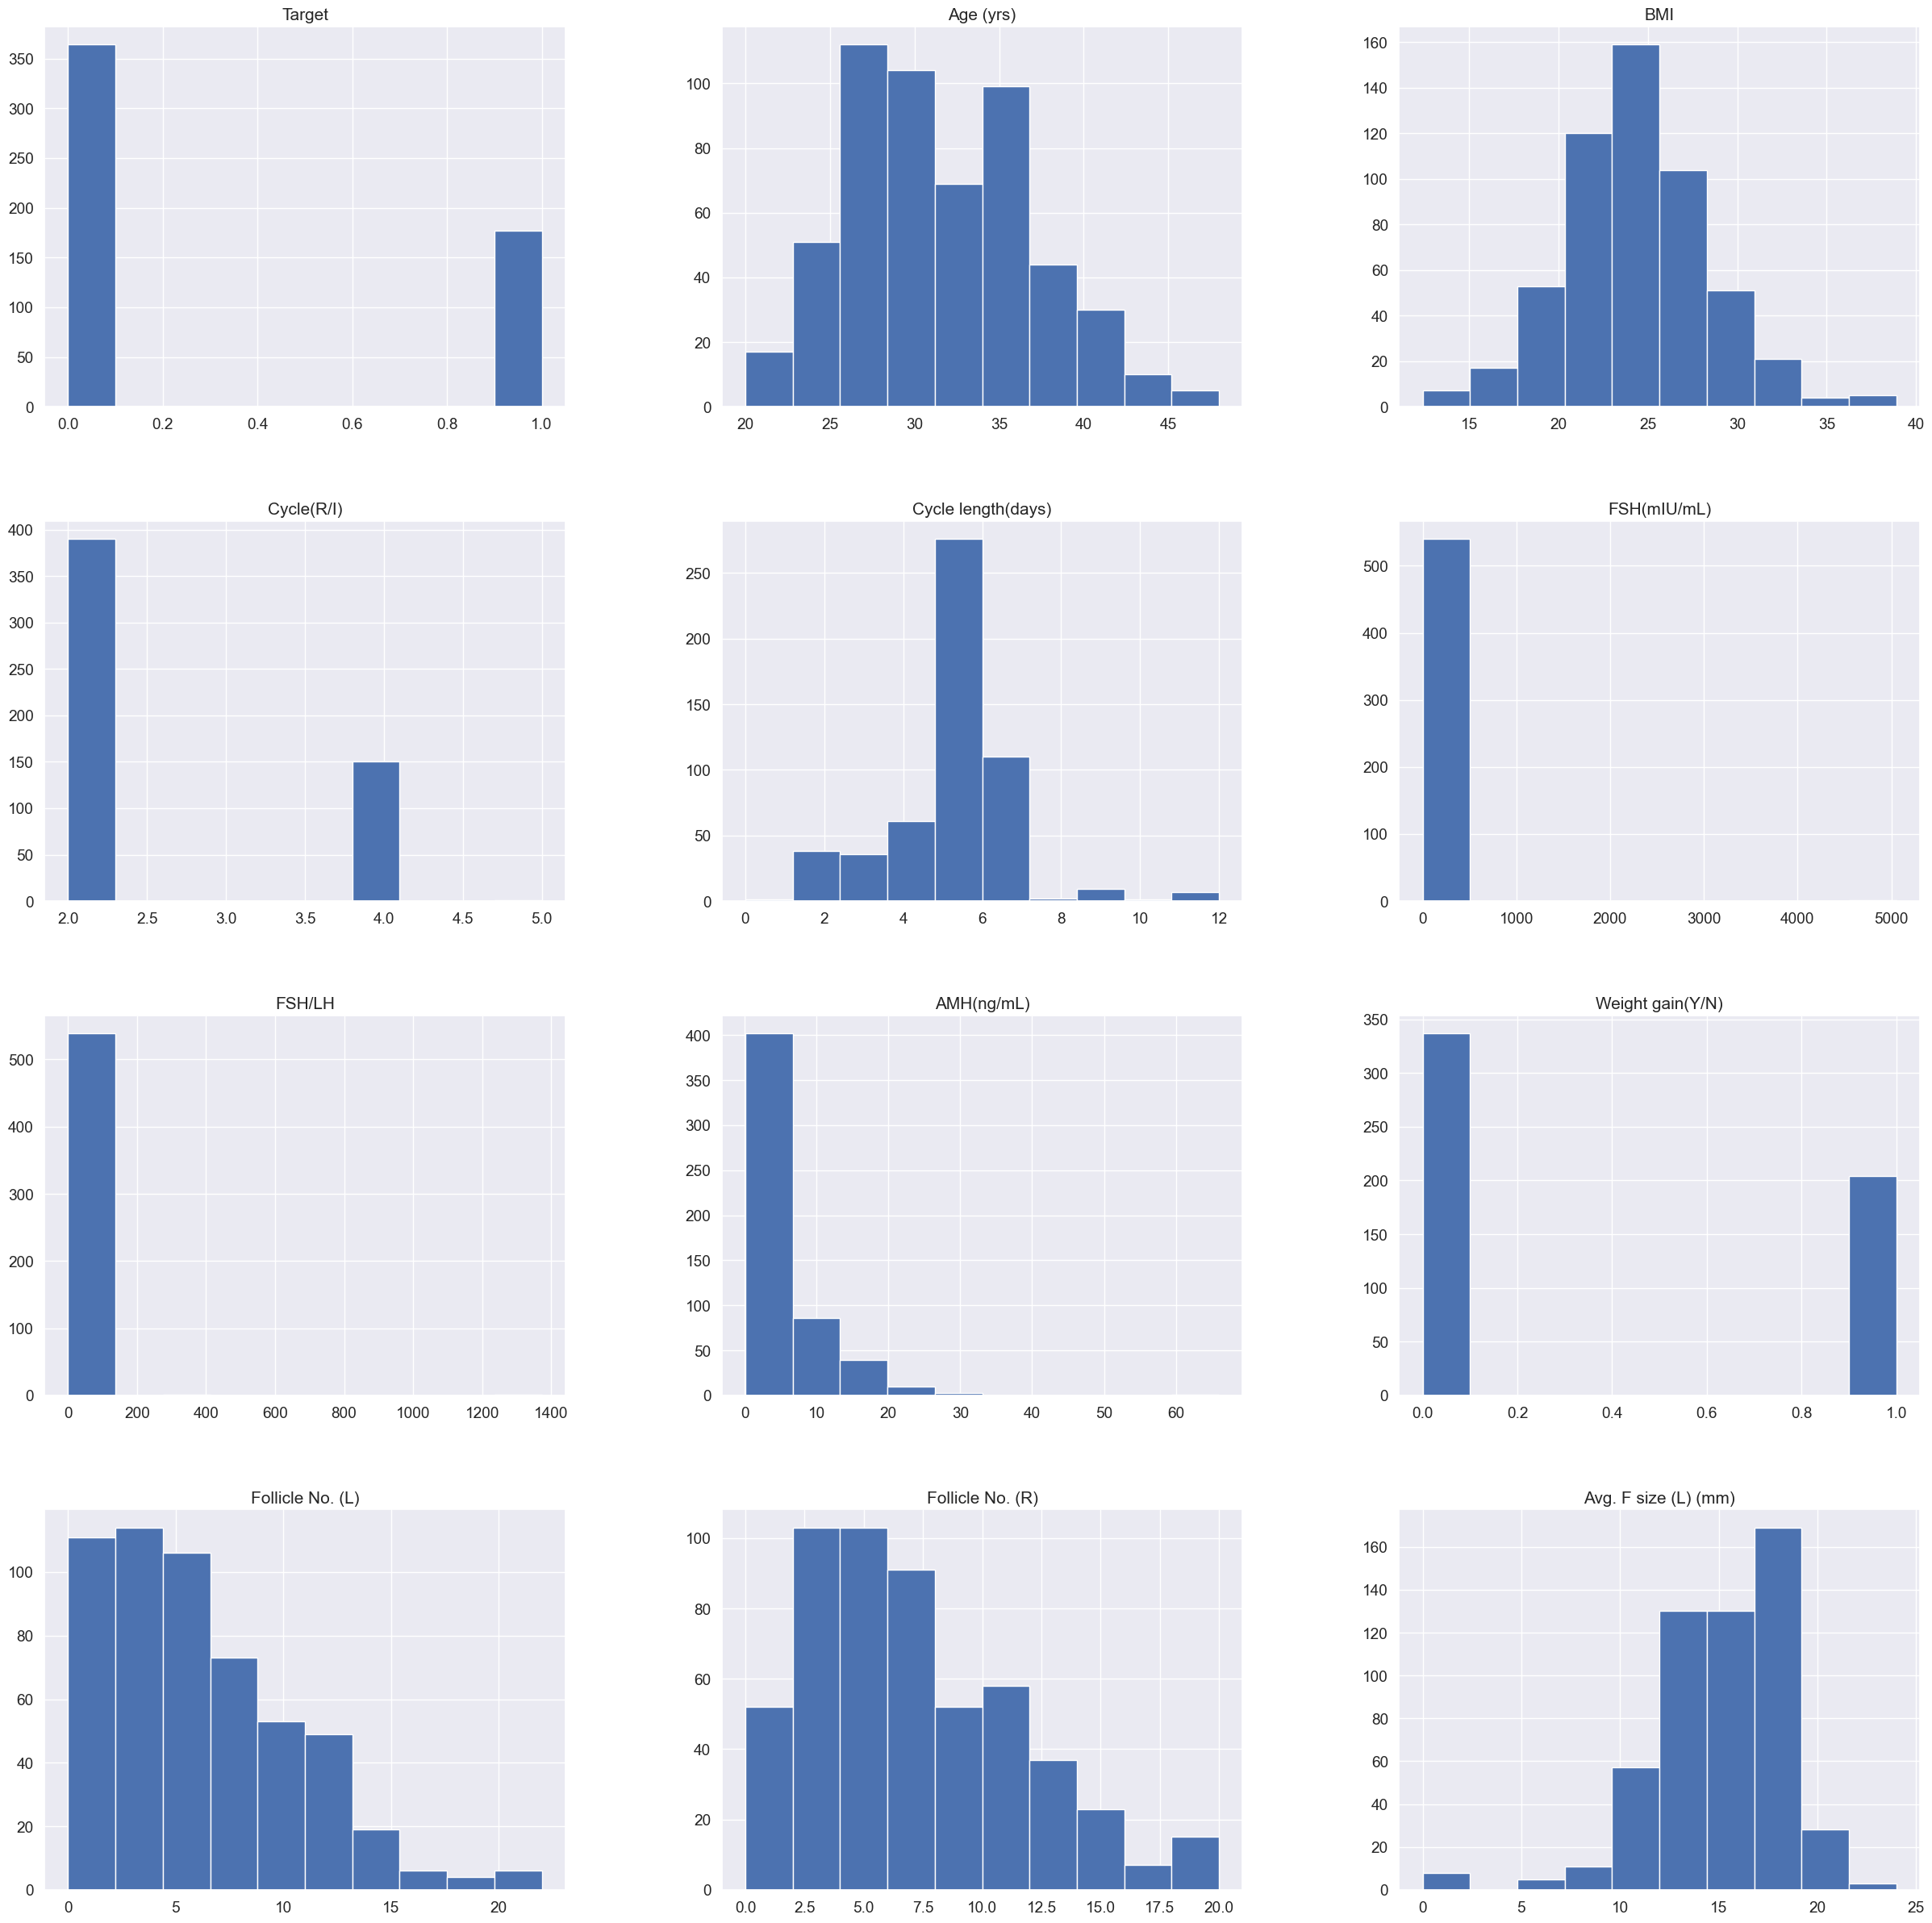

In [31]:
plt = data.hist(figsize = (30,30))

In [32]:
upper_limit = data["Age (yrs)"].mean() + 3*data["Age (yrs)"].std()
upper_limit

47.66370101703488

In [33]:
lower_limit = data["Age (yrs)"].mean() - 3*data["Age (yrs)"].std()
lower_limit

15.197666820303382

In [34]:
upper_limit = data["AMH(ng/mL)"].mean() + 3*data["AMH(ng/mL)"].std()
upper_limit

23.25086063637544

In [35]:
lower_limit = data["AMH(ng/mL)"].mean() - 3*data["AMH(ng/mL)"].std()
lower_limit

-12.009592614194307

In [36]:
data_Outlier=data[(data["Age (yrs)"]>upper_limit) | (data["Age (yrs)"]<lower_limit)]
data_Outlier

,Target,Age (yrs),BMI,Cycle(R/I),Cycle length(days),FSH(mIU/mL),FSH/LH,AMH(ng/mL),Weight gain(Y/N),Follicle No. (L),Follicle No. (R),Avg. F size (L) (mm)
0,0,28,19.3,2,5,7.95,2.16,2.07,0,3,3,18.0
1,0,36,24.9,2,5,6.73,6.17,1.53,0,3,5,15.0
2,1,33,25.3,2,5,5.54,6.30,6.63,0,13,15,18.0
3,0,37,29.7,2,5,8.06,3.42,1.22,0,2,2,15.0
4,0,25,20.1,2,5,3.98,4.42,2.26,0,3,4,16.0
...,...,...,...,...,...,...,...,...,...,...,...,...
535,0,26,30.7,2,5,7.06,2.02,7.60,0,7,9,13.0
536,0,35,18.5,2,5,10.06,5.56,1.70,0,1,0,17.5
537,0,30,25.3,2,5,5.07,1.79,5.60,1,9,7,19.0
538,0,36,23.4,2,6,11.96,4.30,3.70,0,1,0,18.0


## FEATURE SCALING

In [37]:
data.head()

,Target,Age (yrs),BMI,Cycle(R/I),Cycle length(days),FSH(mIU/mL),FSH/LH,AMH(ng/mL),Weight gain(Y/N),Follicle No. (L),Follicle No. (R),Avg. F size (L) (mm)
0,0,28,19.3,2,5,7.95,2.16,2.07,0,3,3,18.0
1,0,36,24.9,2,5,6.73,6.17,1.53,0,3,5,15.0
2,1,33,25.3,2,5,5.54,6.30,6.63,0,13,15,18.0
3,0,37,29.7,2,5,8.06,3.42,1.22,0,2,2,15.0
4,0,25,20.1,2,5,3.98,4.42,2.26,0,3,4,16.0


In [38]:
X = data.drop('Target',axis=1)
y = data['Target']
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,
                                               random_state=42)
y_test

229    0
73     0
352    1
86     0
470    1
      ..
148    1
46     1
93     0
407    0
182    0
Name: Target, Length: 109, dtype: int64

In [39]:
data.head()

,Target,Age (yrs),BMI,Cycle(R/I),Cycle length(days),FSH(mIU/mL),FSH/LH,AMH(ng/mL),Weight gain(Y/N),Follicle No. (L),Follicle No. (R),Avg. F size (L) (mm)
0,0,28,19.3,2,5,7.95,2.16,2.07,0,3,3,18.0
1,0,36,24.9,2,5,6.73,6.17,1.53,0,3,5,15.0
2,1,33,25.3,2,5,5.54,6.30,6.63,0,13,15,18.0
3,0,37,29.7,2,5,8.06,3.42,1.22,0,2,2,15.0
4,0,25,20.1,2,5,3.98,4.42,2.26,0,3,4,16.0


In [48]:
from sklearn.linear_model import LogisticRegression
log = LogisticRegression()
log.fit(X_train,y_train)
LogisticRegression()
y_pred1 = log.predict(X_test)
from sklearn.metrics import accuracy_score
accuracy_score(y_test,y_pred1)

0.8256880733944955

In [49]:
from sklearn import svm
svm = svm.SVC()
svm.fit(X_train,y_train)
SVC()
y_pred2 = svm.predict(X_test)
accuracy_score(y_test,y_pred2)

0.7064220183486238

In [50]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier()
dt.fit(X_train,y_train)
DecisionTreeClassifier()
y_pred3= dt.predict(X_test)
accuracy_score(y_test,y_pred4)

0.7614678899082569

In [51]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf.fit(X_train,y_train)
RandomForestClassifier()
y_pred4= rf.predict(X_test)
accuracy_score(y_test,y_pred5)

0.8440366972477065

In [52]:
from sklearn.ensemble import GradientBoostingClassifier
gbc = GradientBoostingClassifier()
gbc.fit(X_train,y_train)
GradientBoostingClassifier()
y_pred5 = gbc.predict(X_test)
accuracy_score(y_test,y_pred6)

0.8256880733944955

### Result

In [53]:
model_list = ['Decision Tree','SVC','RandomForest','Logistic Regression','XGBRF','CatBoostClassifier']

In [54]:
final_data = pd.DataFrame({'Models':['LR','SVM','DT','RF','GB'],
                          'ACC':[accuracy_score(y_test,y_pred1)*100,
                                accuracy_score(y_test,y_pred2)*100,
                                accuracy_score(y_test,y_pred3)*100,
                                accuracy_score(y_test,y_pred4)*100,
                                accuracy_score(y_test,y_pred5)*100,]})

In [55]:
final_data

,Models,ACC
0,LR,82.568807
1,SVM,70.642202
2,DT,78.899083
3,RF,85.321101
4,GB,82.568807


<AxesSubplot:xlabel='Models', ylabel='ACC'>

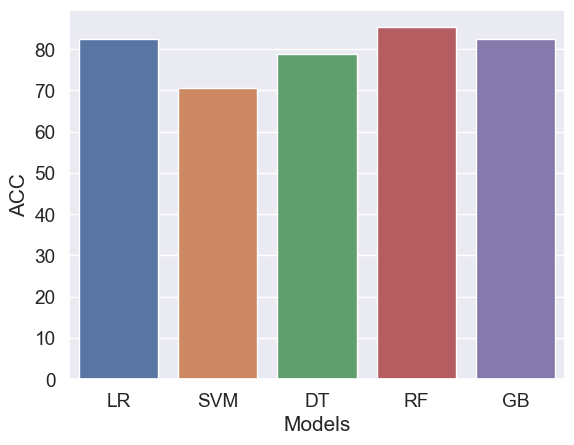

In [56]:
sns.barplot(final_data['Models'],final_data['ACC'])

## prediction on new data

In [57]:
import pandas as pd

In [58]:
new_data = pd.DataFrame({
    'age': 36,
    'Cycle(R/I)': 2,
    'AMH(ng/mL)': 1.53,
    'Weight gain(Y/N)': 0,
    'FSH/LH':6.17,
    'BMI':24.9,
    "Follicle No. (R)":3,
    "Follicle No. (L)": 5, 
    'Avg. F size (L) (mm)':15,
    "FSH(mIU/mL)":6.73,
    "Cycle length(days)":5,   
}, index=[0])

In [59]:
new_data

,age,Cycle(R/I),AMH(ng/mL),Weight gain(Y/N),FSH/LH,BMI,Follicle No. (R),Follicle No. (L),Avg. F size (L) (mm),FSH(mIU/mL),Cycle length(days)
0,36,2,1.53,0,6.17,24.9,3,5,15,6.73,5


In [60]:
p = rf.predict(new_data)
if p[0]==0:
    print("No Disease")
else:
    print("Disease")

Disease


In [61]:
import joblib
joblib.dump(rf,'model_joblib_pcos1')

model = joblib.load('model_joblib_pcos1')
model.predict(new_data)

data.tail()

,Target,Age (yrs),BMI,Cycle(R/I),Cycle length(days),FSH(mIU/mL),FSH/LH,AMH(ng/mL),Weight gain(Y/N),Follicle No. (L),Follicle No. (R),Avg. F size (L) (mm)
536,0,35,18.5,2,5,10.06,5.56,1.7,0,1,0,17.5
537,0,30,25.3,2,5,5.07,1.79,5.6,1,9,7,19.0
538,0,36,23.4,2,6,11.96,4.30,3.7,0,1,0,18.0
539,0,27,22.2,4,2,4.40,1.02,5.2,0,7,6,18.0
540,1,23,30.1,4,7,3.99,0.93,20.0,1,9,10,19.0


In [62]:
from tkinter import *
import joblib

In [ ]:
def show_entry_fields():
    p1=int(e1.get())
    p2=int(e2.get())
    p3=int(e3.get())
    p4=int(e4.get())
    p5=int(e5.get())
    p6=int(e6.get())
    p7=int(e7.get())
    p8=int(e8.get())
    p9=int(e9.get())
    p10=int(e10.get())
    p11=int(e11.get())
    
    model = joblib.load('model_joblib_pcos1')
    result=model.predict([[p1,p2,p3,p4,p5,p6,p7,p8,p8,p10,p11,p12,p13]])
    
    if result == 0:
        Label(master, text="No PCOS").grid(row=31)
    else:
        Label(master, text="Possibility of PCOS").grid(row=31)
    
    
master = Tk()
master.title("PCOS detection System")

label = Label(master, text = "PCOS detection System"
                          , bg = "black", fg = "white"). \
                               grid(row=0,columnspan=2)


Label(master, text="Enter Your Age").grid(row=1)
Label(master, text="Enter your BMI Value").grid(row=2)
Label(master, text="Enter your Cycle length").grid(row=3)
Label(master, text="Enter Value of Cycle(R/I)").grid(row=4)
Label(master, text="Enter Value of AMH(ng/mL)").grid(row=5)
Label(master, text="Enter Value of FSH/LH").grid(row=6)
Label(master, text="Enter Value of FSH(mIU/mL)").grid(row=7)
Label(master, text="Enter Value of Weight gain(Y/N)").grid(row=8)
Label(master, text="Enter Value of Follicle No. (L)").grid(row=9)
Label(master, text="Enter Value of Follicle No. (R)").grid(row=10)
Label(master, text="Enter Value of Avg. F size (L) (mm)").grid(row=11)




e1 = Entry(master)
e2 = Entry(master)
e3 = Entry(master)
e4 = Entry(master)
e5 = Entry(master)
e6 = Entry(master)
e7 = Entry(master)
e8 = Entry(master)
e9 = Entry(master)
e10 = Entry(master)
e11 = Entry(master)
e1.grid(row=1, column=1)
e2.grid(row=2, column=1)
e3.grid(row=3, column=1)
e4.grid(row=4, column=1)
e5.grid(row=5, column=1)
e6.grid(row=6, column=1)
e7.grid(row=7, column=1)
e8.grid(row=8, column=1)
e9.grid(row=9, column=1)
e10.grid(row=10, column=1)
e11.grid(row=11, column=1)



Button(master, text='Predict', command=show_entry_fields).grid()

mainloop()